In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from data_clean.loadData import getTickers
from sklearn.cluster import affinity_propagation

import yfinance as yf

In [2]:
DOWNLOAD_DATA = False

In [3]:
if DOWNLOAD_DATA:
    with open("../data/tickers.txt", "r") as f:
        tickers = [ticker.strip() for ticker in f.readlines()]

    df = yf.download(tickers, start='2005-01-01', end='2021-12-31')['Adj Close']
else:
    df = pd.read_csv('../data/all_ticker_data.csv', index_col=0, parse_dates=True)

In [4]:
# split datafram into years
# get min and max year
min_year = df.index.min().year
max_year = df.index.max().year

years = [df.loc[f'{year}-01-01':f'{year}-12-31'] for year in range(min_year, max_year + 1)]

len(years)

17

In [81]:
def backtest(tickers=years[-1].columns, year=max_year, baseline=False):
    """
    Backtest a portfolio of tickers on a given year assuming an equal weight portfolio

    Parameters
    ----------
    tickers : list
        list of tickers to backtest
    year : int
        year to backtest

    Returns
    -------
    float
        portfolio percent return
    """
    if year < min_year or year > max_year:
        raise ValueError(f"year must be between {min_year} and {max_year}")

    # get the data for the year
    year_data = years[year - min_year]

    # get the data for the tickers
    year_data = year_data[tickers]

    # drop tickers that don't have data for the year
    year_data = year_data.dropna(axis=1)

    
    # year returns
    year_returns = year_data.pct_change()[1:]

    # fill NaN with 0
    year_returns = year_returns.fillna(0)

    # portfolio return
    portfolio_returns = year_returns.mean(axis=1)


    # returns up to any given date
    yearly_return =  (portfolio_returns + 1).cumprod()

    return yearly_return - 1

In [92]:
from sklearn.cluster import AffinityPropagation as AP, affinity_propagation
import networkx as nx

year = 2020

# get the data for the year
year_data = years[year - min_year]

# remove tickers that don't have any variation during the year
year_variation = np.var(year_data, axis=0)
year_data = year_data[year_variation[year_variation > 0].index]

# drop tickers that don't have data for the year
year_data = year_data.dropna(axis=1, how='any')

corr_df = year_data.corr().to_numpy()

# make corr_df into a graph
G = nx.from_numpy_matrix(corr_df)

A = nx.to_scipy_sparse_matrix(G)


clustering = AP().fit(A)

In [93]:
cluster_centers_indices = clustering.cluster_centers_indices_
labels = clustering.labels_


In [94]:
symbols = np.array(year_data.columns).T

In [95]:
cluster_tickers = list(symbols[cluster_centers_indices])

In [98]:
years[-1]

,A,AAALY,AACAY,AAL,AAME,AAOI,AAON,AAP,AAPL,AAT,...,ZBRA,ZDPY,ZEUS,ZIJMF,ZION,ZNH,ZSHGY,ZTS,ZUMZ,ZURVY
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,118.001701,17.368872,5.549762,15.130000,2.117186,8.76,63.947849,149.533600,127.874924,26.555883,...,378.130005,0.416,13.940760,1.157130,40.739872,29.990000,64.977661,162.432663,35.700001,38.408039
2021-01-05,118.966484,17.368872,5.747968,15.430000,2.572282,8.91,64.669258,149.372055,129.455948,26.798271,...,380.570007,0.405,14.817599,1.166772,41.385185,30.360001,64.977661,163.564590,36.080002,38.779003
2021-01-06,122.228828,17.368872,5.747968,15.520000,2.275480,9.58,68.068733,158.001511,125.098267,27.845383,...,394.820007,0.426,16.058969,1.195701,46.035202,29.719999,64.977661,165.967484,39.209999,39.638546
2021-01-07,125.481255,17.368872,5.658775,15.380000,2.334841,9.64,69.640007,159.351074,129.367020,27.321827,...,409.100006,0.385,15.861926,1.234272,47.439697,29.340000,64.977661,165.818558,39.389999,39.566162
2021-01-08,126.376396,17.368872,5.807430,15.130000,2.384308,10.19,68.493668,161.622498,130.483627,27.360611,...,405.470001,0.370,14.797896,1.224629,46.234486,28.820000,64.977661,166.920700,40.040001,39.457592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,157.592438,31.853800,3.900000,18.260000,3.192363,5.64,78.056458,224.063004,175.262817,36.360001,...,582.409973,0.777,22.349117,1.181641,60.688778,28.379999,77.139977,242.121170,45.900002,41.380154
2021-12-27,158.531204,31.853800,3.930000,18.170000,3.043187,5.59,79.288353,228.281128,179.289459,36.730000,...,606.330017,0.730,22.615999,1.171875,61.321358,28.660000,76.755753,246.114746,47.770000,41.427715
2021-12-28,158.970612,31.853800,3.910000,18.540001,3.112803,5.48,78.831360,229.854507,178.255432,36.580002,...,597.320007,0.756,22.467731,1.181641,61.418678,29.010000,76.918304,243.858383,47.570000,41.846275


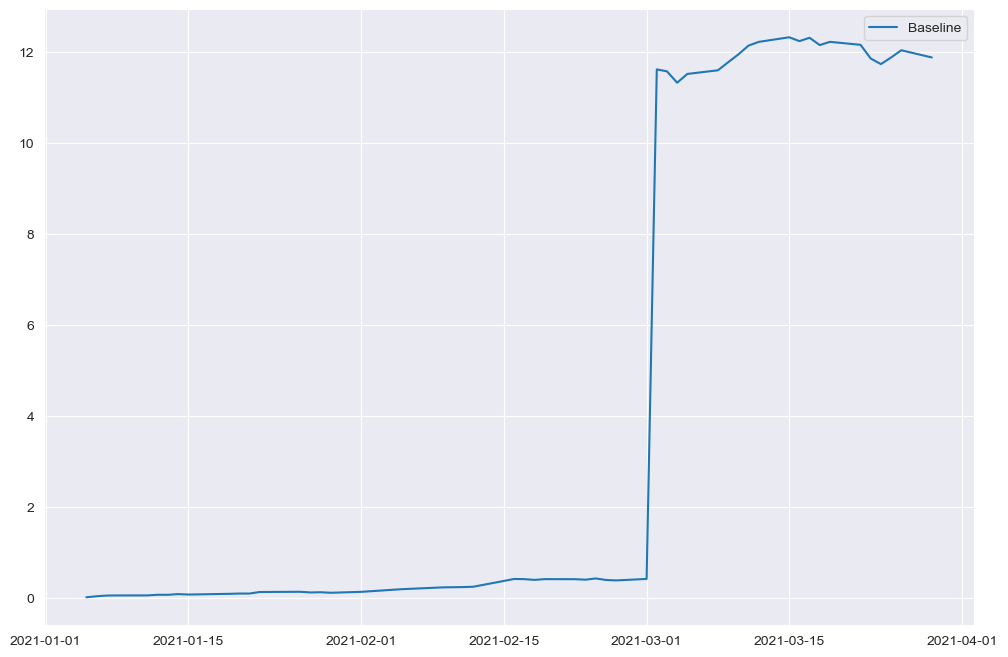

In [97]:
baseline = backtest(year=2021)
# cluster_tickers = backtest(tickers=cluster_tickers, year=year + 1)
sns.set_style('darkgrid')
plt.figure(figsize=(12, 8))
plt.plot(baseline, label='Baseline')
# plt.plot(cluster_tickers, label='Cluster tickers')
plt.legend()